# Group 5: 
# Green technology: Visualizations

## Theory of change

Places with larger networks (as represented by a larger number of PIs) would be more innovative (produce more patents with a given amount of funding) than places with smaller networks (where there are fewer opportunities for diffusion of knowledge).

Our unit of analysis is places.

## Analysis outline

We defining our outcome of interest as the number of patents produced within a given city as a function of the number of PIs (and associated researchers) and the dollar amount of grants received.

The data will be linked between the grants and patents via the PI name (or other project members) and the organization. Data will be summarized on the city level. A regression wil be run on the above variables.

## Set up

In [1]:
# os tools
import glob as glob
import os
import openpyxl

# data manipulation
import pandas as pd
import numpy as np

# record linkage
from recordlinkage.preprocessing import clean, phonetic

# text analysis tools
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import preprocessing
from nltk import SnowballStemmer
from nltk.corpus import stopwords
import string

import geopandas as gpd
import matplotlib.pyplot as plt

# for plotting
from plotnine import * 
theme_set(theme_minimal())

# for regression
import statsmodels.formula.api as sm

# show all columns when printing dataframe
pd.set_option('display.max_columns', None)

# set working directory
#%cd "/home/joemarlo/Dropbox/School/NYU/2021_Spring/PADMGP2505_BigData"
%cd "/Users/smritimohta/Desktop/BDAPP"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

/Users/smritimohta/Desktop/BDAPP


## Building visualizations on the work done in main notebook

From the main notebook, we created 2 CSV files constaining final no. of PIs, grants funding and No. of patents in green tech. We will be using these here to do some visualizations. 

In [2]:
city_summary = pd.read_csv("city_summary.csv")
city_summary.head()

,city,n_pis,grant_cost,n_patents
0,"New York, NY",577,341316346.0,0.0
1,"East Lansing, MI",538,85371245.0,0.0
2,"Madison, WI",457,144817731.0,1.0
3,"Boston, MA",452,298834077.0,11.0
4,"Gainesville, FL",443,126794744.0,0.0


In [3]:
city_locations = pd.read_csv("city_locations.csv")
city_locations.head()

,city,n_pis,grant_cost,n_patents,ZIP,geopoint
0,"Aberdeen Proving Ground, MD",1,0.0,0.0,21010.0,"39.344808,-76.27313"
1,"Aberdeen, ID",5,2023606.0,0.0,83210.0,"42.97228,-112.83218"
2,"Accokeek, MD",1,1010000.0,0.0,20607.0,"38.672216,-77.01807"
3,"Adelphi, MD",1,1712675.0,0.0,20783.0,"38.98941,-76.97294"
4,"Adrian, MI",5,641751.0,0.0,49221.0,"41.900927,-84.04585"


In [4]:
# extracting lat and long values
city_locations['latitude'] = city_locations['geopoint'].str.split(',').str.get(0)
city_locations['longitude'] = city_locations['geopoint'].str.split(',').str.get(1)

city_locations.head()

,city,n_pis,grant_cost,n_patents,ZIP,geopoint,latitude,longitude
0,"Aberdeen Proving Ground, MD",1,0.0,0.0,21010.0,"39.344808,-76.27313",39.344808,-76.27313
1,"Aberdeen, ID",5,2023606.0,0.0,83210.0,"42.97228,-112.83218",42.97228,-112.83218
2,"Accokeek, MD",1,1010000.0,0.0,20607.0,"38.672216,-77.01807",38.672216,-77.01807
3,"Adelphi, MD",1,1712675.0,0.0,20783.0,"38.98941,-76.97294",38.98941,-76.97294
4,"Adrian, MI",5,641751.0,0.0,49221.0,"41.900927,-84.04585",41.900927,-84.04585


In [5]:
# converting the dataframe to geo-dataframe
geo_city_locations = gpd.GeoDataFrame(city_locations, geometry=gpd.points_from_xy(city_locations.longitude, city_locations.latitude))
geo_city_locations.head()

,city,n_pis,grant_cost,n_patents,ZIP,geopoint,latitude,longitude,geometry
0,"Aberdeen Proving Ground, MD",1,0.0,0.0,21010.0,"39.344808,-76.27313",39.344808,-76.27313,POINT (-76.27313 39.34481)
1,"Aberdeen, ID",5,2023606.0,0.0,83210.0,"42.97228,-112.83218",42.97228,-112.83218,POINT (-112.83218 42.97228)
2,"Accokeek, MD",1,1010000.0,0.0,20607.0,"38.672216,-77.01807",38.672216,-77.01807,POINT (-77.01807 38.67222)
3,"Adelphi, MD",1,1712675.0,0.0,20783.0,"38.98941,-76.97294",38.98941,-76.97294,POINT (-76.97294 38.98941)
4,"Adrian, MI",5,641751.0,0.0,49221.0,"41.900927,-84.04585",41.900927,-84.04585,POINT (-84.04585 41.90093)


In [6]:
# setting the coordinate systems
geo_city_locations.crs = "epsg:4326"
geo_city_locations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
# reading US Census States shapefile
states = gpd.read_file('/Users/smritimohta/Desktop/geopandas-tutorial/data/usa-states-census-2014.shp')
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,region,geometry
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,..."
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,Northeast,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04..."
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,Southeast,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47..."
4,16,01779783,0400000US16,16,ID,Idaho,00,214045425549,2397728105,West,"POLYGON Z ((-117.24303 44.39097 0.00000, -117...."


In [8]:
#converting crs of states shapefile to match crs of city locations dataframe
states['geometry'] = states['geometry'].to_crs(epsg=4326)
states.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# reading US Census counties shapefile
county = gpd.read_file("/Users/smritimohta/Desktop/BDAPP/cb_2019_us_all_5m/cb_2019_us_county_5m/cb_2019_us_county_5m.shp")
county.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,24,510,01702381,0500000US24510,24510,Baltimore,25,209650970,28758714,"POLYGON ((-76.71131 39.37193, -76.62619 39.372..."
1,31,169,00835906,0500000US31169,31169,Thayer,06,1486153245,3025339,"POLYGON ((-97.82082 40.35054, -97.36869 40.350..."
2,37,077,01008556,0500000US37077,37077,Granville,06,1377850155,14503653,"POLYGON ((-78.80252 36.21349, -78.80235 36.220..."
3,46,091,01265759,0500000US46091,46091,Marshall,06,2170724143,124586482,"POLYGON ((-97.97924 45.76257, -97.97878 45.935..."
4,39,075,01074050,0500000US39075,39075,Holmes,06,1094405864,3695230,"POLYGON ((-82.22066 40.66758, -82.12620 40.668..."


In [10]:
#setting crs of states shapefile to match crs of city locations dataframe
county.crs = "epsg:4326"
county.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
# performing a spatial join on city locations within US counties
points_in_county = gpd.sjoin(geo_city_locations,county,op="within", how="right")
points_in_county.tail()

,index_left,city,n_pis,grant_cost,n_patents,ZIP,geopoint,latitude,longitude,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
3229,520.0,"Kent, OH",12.0,2730876.0,0.0,44242.0,"41.170006,-81.196615",41.170006,-81.196615,39,133,01074079,0500000US39133,39133,Portage,06,1262370046,43127727,"POLYGON ((-81.39328 41.02544, -81.39322 41.040..."
3229,384.0,"Garrettsville, OH",1.0,149902.0,2.0,44231.0,"41.295898,-81.08057",41.295898,-81.08057,39,133,01074079,0500000US39133,39133,Portage,06,1262370046,43127727,"POLYGON ((-81.39328 41.02544, -81.39322 41.040..."
3230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08,025,00198128,0500000US08025,08025,Crowley,06,2039427872,33422981,"POLYGON ((-104.05840 38.26084, -104.05392 38.5..."
3231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,227,01673011,0500000US13227,13227,Pickens,06,601031022,1690669,"POLYGON ((-84.65437 34.54895, -84.52139 34.550..."
3232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,145,00516925,0500000US21145,21145,McCracken,06,644190803,50358595,"POLYGON ((-88.93308 37.22775, -88.93174 37.227..."


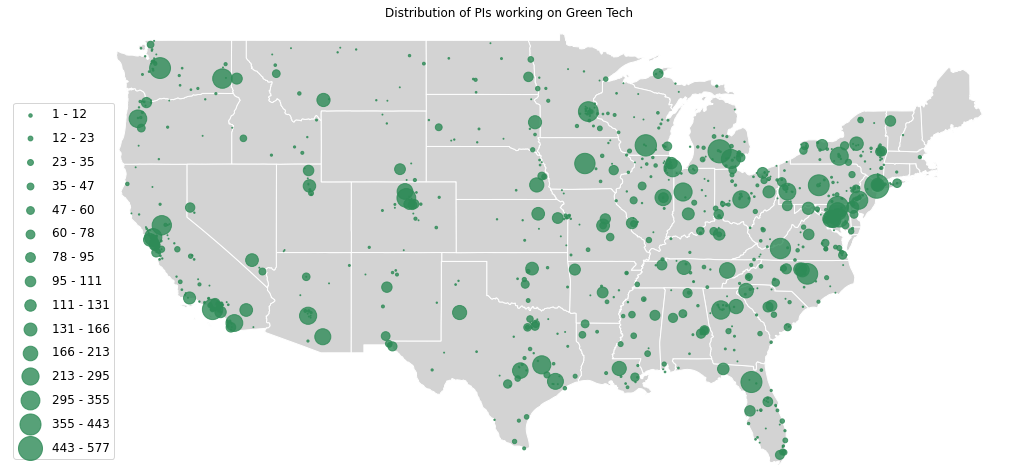

In [12]:
# Visualization: Distribution of PIs working on Green Tech
base_state = states.plot(figsize=(18,18), color='lightgrey', edgecolor='white')
geo_city_locations.plot(ax=base_state, markersize=geo_city_locations.n_pis , legend=True, categorical=True, 
                        alpha=0.8, color='seagreen')
base_state.set_title("Distribution of PIs working on Green Tech")

lims = base_state.axis([-132,-65,25,50])
base_state.set_axis_off()

sizes = list(geo_city_locations.n_pis.unique())
sizes = sorted(sizes, reverse=False)
sizes = [int(x) for x in sizes]

for i in range(11,len(sizes),11):
    plt.scatter([0],[0],sizes[i], c='seagreen', label= '{} - {}'.format(sizes[i-11],sizes[i]), alpha=0.8)

plt.scatter([0],[0],sizes[158], c='seagreen', label= '443 - 577', alpha=0.8)
plt.legend(scatterpoints=1, frameon=True,
        labelspacing=0.9, loc='lower left', fontsize=12, 
        bbox_to_anchor=(0., 0., 1, 0.2), title_fontsize=20);
plt.show()


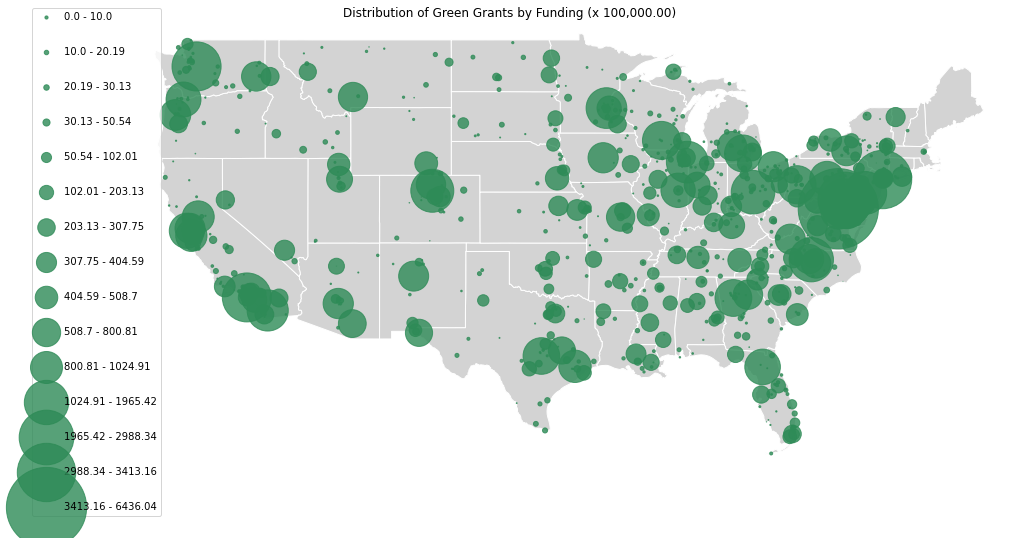

In [13]:
# Visualization: Distribution of Green Grants by Cost/Funding
base_state = states.plot(figsize=(18,18), color='lightgrey', edgecolor='white')
geo_city_locations.plot(ax=base_state, markersize=(geo_city_locations['grant_cost']/100000) , legend=True, alpha=0.8, color='seagreen')
base_state.set_title("Distribution of Green Grants by Funding (x 100,000.00)")

lims = base_state.axis([-135,-65,20,50])
base_state.set_axis_off()

sizes = geo_city_locations['grant_cost']/100000
sizes = list(sizes.unique())
sizes = sorted(sizes, reverse=False)
sizes = [round(x,2) for x in sizes]

plt.scatter([0],[0],sizes[532], c='seagreen', label='{} - {}'.format(sizes[0],sizes[532]), alpha=0.8)
plt.scatter([0],[0],sizes[654], c='seagreen', label='{} - {}'.format(sizes[532],sizes[654]), alpha=0.8)
plt.scatter([0],[0],sizes[720], c='seagreen', label='{} - {}'.format(sizes[654],sizes[720]), alpha=0.8)
plt.scatter([0],[0],sizes[772], c='seagreen', label='{} - {}'.format(sizes[720],sizes[772]), alpha=0.8)
plt.scatter([0],[0],sizes[824], c='seagreen', label='{} - {}'.format(sizes[772],sizes[824]), alpha=0.8)
plt.scatter([0],[0],sizes[870], c='seagreen', label='{} - {}'.format(sizes[824],sizes[870]), alpha=0.8)
plt.scatter([0],[0],sizes[912], c='seagreen', label='{} - {}'.format(sizes[870],sizes[912]), alpha=0.8)
plt.scatter([0],[0],sizes[940], c='seagreen', label='{} - {}'.format(sizes[912],sizes[940]), alpha=0.8)
plt.scatter([0],[0],sizes[953], c='seagreen', label='{} - {}'.format(sizes[940],sizes[953]), alpha=0.8)
plt.scatter([0],[0],sizes[968], c='seagreen', label='{} - {}'.format(sizes[953],sizes[968]), alpha=0.8)

plt.scatter([0],[0],sizes[985], c='seagreen', label='{} - {}'.format(sizes[968],sizes[985]), alpha=0.8)
plt.scatter([0],[0],sizes[1006], c='seagreen', label='{} - {}'.format(sizes[985],sizes[1006]), alpha=0.8)
plt.scatter([0],[0],sizes[1010], c='seagreen', label='{} - {}'.format(sizes[1006],sizes[1010]), alpha=0.8)
plt.scatter([0],[0],sizes[1011], c='seagreen', label='{} - {}'.format(sizes[1010],sizes[1011]), alpha=0.8)
plt.scatter([0],[0],sizes[1012], c='seagreen', label='{} - {}'.format(sizes[1011],sizes[1012]), alpha=0.8)


legend1 = plt.legend(scatterpoints=1, frameon=True,
        labelspacing=2.5, loc='lower left', fontsize=10, bbox_to_anchor=(0.02, 0.02, 0.8, 0.2), 
        title_fontsize=20);
plt.show()

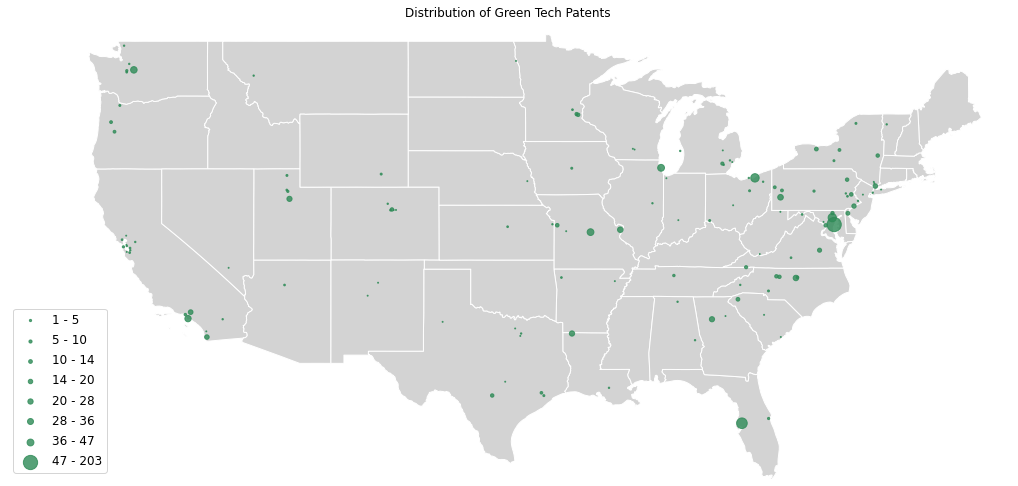

In [14]:
# Visualization: Distribution of Green Tech Patents
base_state = states.plot(figsize=(18,18), color='lightgrey', edgecolor='white')
geo_city_locations.plot(ax=base_state, markersize=geo_city_locations.n_patents , legend=True, categorical=True, 
                        alpha=0.8, color='seagreen')
base_state.set_title("Distribution of Green Tech Patents ")

lims = base_state.axis([-130,-65,25,50])
base_state.set_axis_off()

sizes = list(geo_city_locations.n_patents.unique())
sizes = sorted(sizes, reverse=False)
sizes = [int(x) for x in sizes]

for i in range(5,len(sizes),4):
    plt.scatter([0],[0],sizes[i], c='seagreen', label= '{} - {}'.format(sizes[i-4],sizes[i]), alpha=0.8)

plt.legend(scatterpoints=1, frameon=True,
        labelspacing=0.6, loc='lower left', fontsize=12, 
        bbox_to_anchor=(0., 0., 1, 0.2), title_fontsize=20);
plt.show()

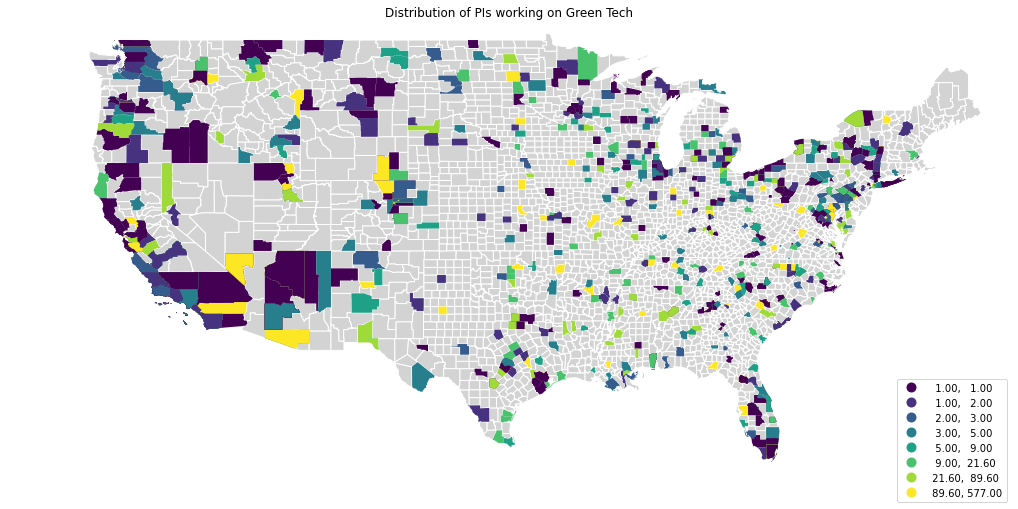

In [15]:
# Chloropleth visualizations: Distribution of PIs working on Green Tech
base_county = county.plot(figsize=(18,18), color='lightgrey', edgecolor = 'white')
points_in_county.plot(ax=base_county,column='n_pis',scheme='quantiles', legend=True, k=10)
base_county.set_title("Distribution of PIs working on Green Tech")

lims = base_county.axis([-130,-65,25,50])
base_county.set_axis_off()
#base_county.legend(loc='lower right')
leg = base_county.get_legend()
leg.set_bbox_to_anchor((0., 0., 1, 0.2))



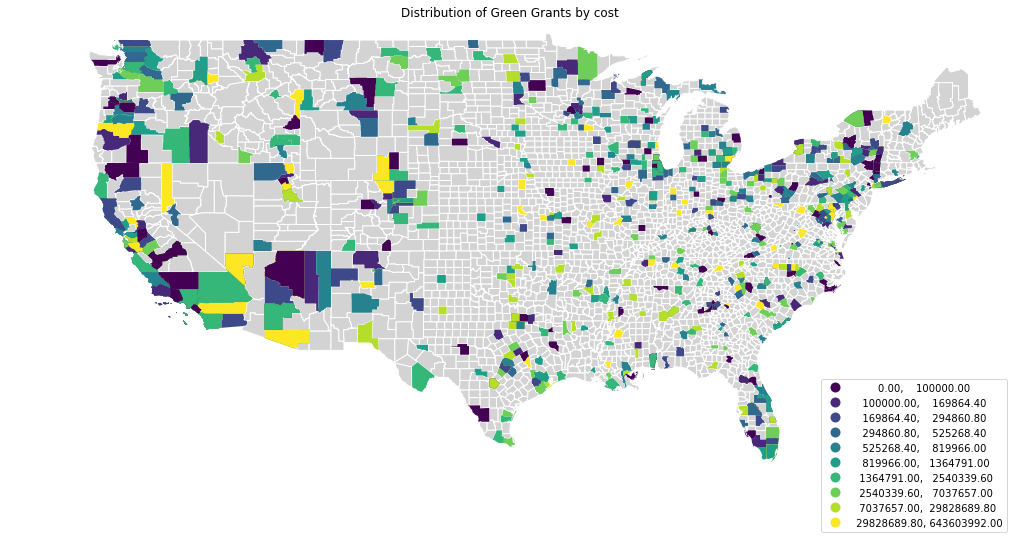

In [16]:
# Chloropleth visualizations: Distribution of Green Grants by cost
base_county = county.plot(figsize=(18,18), color='lightgrey', edgecolor='white')
points_in_county.plot(ax=base_county,column='grant_cost',scheme='quantiles', legend=True, k=10)
base_county.set_title("Distribution of Green Grants by cost")

lims = base_county.axis([-130,-65,25,50])
base_county.set_axis_off()
leg = base_county.get_legend()
leg.set_bbox_to_anchor((0., 0., 1, 0.2))

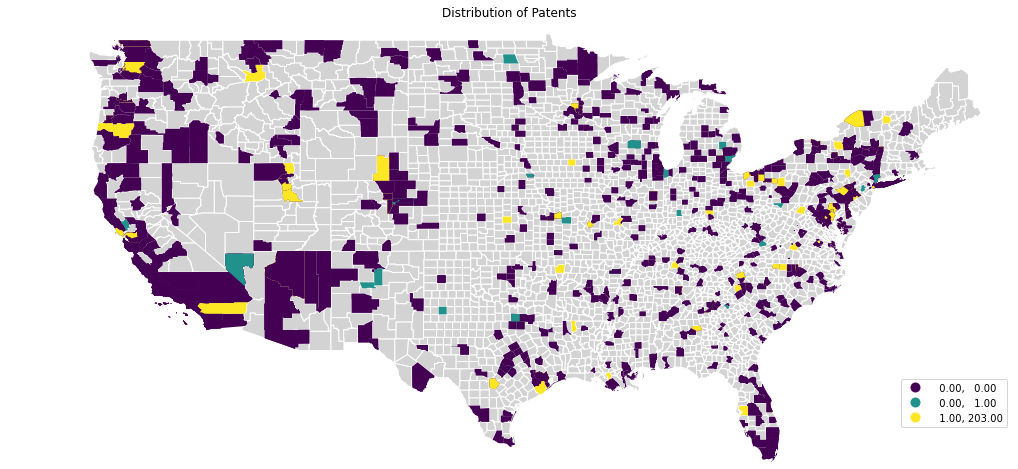

In [17]:
# Chloropleth visualizations: Distribution of Green Tech Patents
base_county = county.plot(figsize=(18,18), color='lightgrey', edgecolor='white')
points_in_county.plot(ax=base_county,column='n_patents',scheme='quantiles', legend=True, k=10)
base_county.set_title("Distribution of Patents")

lims = base_county.axis([-130,-65,25,50])
base_county.set_axis_off()
leg = base_county.get_legend()
leg.set_bbox_to_anchor((0., 0., 1, 0.2))